In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, roc_auc_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Lab 4: Fire and Tree Mortality

# About the data
Wildfires are increasingly frequent and severe due to climate change. Predicting tree mortality following a wildfire is critical for forest management, ecosystem recovery, and carbon sequestration planning. In this lab, we will build a logistic regression model to predict the probability of tree mortality one year after a wildfire

The database we'll be working with today includes observations of individual trees involved in prescribed fires and wildfires occurring over 35 years, from 1981 to 2016. It is drawn from a fire and tree mortality database from the US Forest Service (see data description for the full database here: [link](https://www.nature.com/articles/s41597-020-0522-7#Sec10)).

The target variable we'll use is `yr1status`, which is a binary variable (0=alive, 1=dead).  This tells us if a tree has died one year after a fire event.

The features we'll use are `YrFireName`, `Times_burned`, `Species`, `Genus_species`,
    `DBH_cm`, `HT_m`, `CR_pre`, and `CR_post`.

## Step 1: Check the metadata

Look at the metadata and provide a description on what each variable represents in the Description column below.


| Feature                     | Description                                                                                   |
|-----------------------------|-----------------------------------------------------------------------------------------------| 
| yr1status                   | The status of the tree in year 1 post fire: 0=alive, 1=dead
| YrFireName                  | Unique identifier                                   
| Times_burned                | The number of times this tree was burned                                
| Species                     | Species of tree: First two letters of genus and first two letters of species                                                    
| Genus_species               |   Genus of species                                     
| DBH_cm                      | Diameter at breast height (nearest 0.1 cm)
| HT_m                        | Pre-fire tree height in meters 
| CR_pre                      | Pre fire live crown ratio: crown length divided by tree height 
| CR_post                     | Post fire live crown ratio: crown length divided by tree height 

## Step 2: Fetch  data
Read in the data set and filter to retain only the variables of interest.  Then check for incomplete observations and remove any rows containing NaNs.  How many observations does that leave us with? **Print your answer.**

In [2]:
# Load the dataset
trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')

/tmp/ipykernel_1387830/1765753220.py:2: DtypeWarning: Columns (4,5,6,7,10,62,63) have mixed types. Specify dtype option on import or set low_memory=False.
  trees_dat = pd.read_csv('/courses/EDS232/Data/FTM_trees.csv')


In [3]:
# Filter to columns of interest 
trees_clean = trees_dat[['yr1status','YrFireName', 'Times_burned', 'Species', 'Genus_species', 'DBH_cm', 'HT_m', 'CR_pre','CR_post']]

In [4]:
# Check for rows with NAs 
na_counts = trees_clean.isna().sum()
print(na_counts)

# Determine how many rows there are pre-removal of NAs 
print(f'Number of rows pre NA filter: {len(trees_clean)}')

yr1status         33263
YrFireName            0
Times_burned          0
Species               0
Genus_species         0
DBH_cm             3973
HT_m              61650
CR_pre           119342
CR_post          130605
dtype: int64
Number of rows pre NA filter: 169843


In [5]:
# Drop rows with NAs 
trees_complete = trees_clean.dropna(axis=0)

# Print number of rows post NA removal
print(f'Number of rows post NA filter: {len(trees_complete)}')

Number of rows post NA filter: 36509


## Step 3: Data Preprocessing
1. We recode categorical predictors to zero-based integer form because most machine learning models, including logistic regression, cannot work directly with categorical data represented as strings or labels. Instead, models require numerical input. Let's do that here. 


In [6]:
# View data types of df to find categoricals 
trees_complete.dtypes

yr1status        float64
YrFireName        object
Times_burned       int64
Species           object
Genus_species     object
DBH_cm           float64
HT_m             float64
CR_pre           float64
CR_post          float64
dtype: object

In [7]:
# Convert YrFireName, Species, Genus_species using .cat.codes
trees_complete['YrFireName_cat'] = trees_complete['YrFireName'].astype('category').cat.codes
trees_complete['Species_cat'] = trees_complete['Species'].astype('category').cat.codes
trees_complete['Genus_species_cat'] = trees_complete['Genus_species'].astype('category').cat.codes

# View dataframe 
trees_complete.head(10)

/tmp/ipykernel_1387830/2124077161.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_complete['YrFireName_cat'] = trees_complete['YrFireName'].astype('category').cat.codes
/tmp/ipykernel_1387830/2124077161.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trees_complete['Species_cat'] = trees_complete['Species'].astype('category').cat.codes
/tmp/ipykernel_1387830/2124077161.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,c

,yr1status,YrFireName,Times_burned,Species,Genus_species,DBH_cm,HT_m,CR_pre,CR_post,YrFireName_cat,Species_cat,Genus_species_cat
500,0.0,2003 - Griff,1,ABAM,Abies_amabilis,71.374,41.76,0.84,0.74,37,0,0
501,0.0,2003 - Griff,1,ABAM,Abies_amabilis,23.622,12.80,0.60,0.57,37,0,0
502,0.0,2003 - Griff,1,ABAM,Abies_amabilis,46.228,34.75,0.75,0.59,37,0,0
503,0.0,2003 - Griff,1,ABAM,Abies_amabilis,21.082,23.16,0.38,0.38,37,0,0
504,0.0,2003 - Griff,1,ABAM,Abies_amabilis,24.384,26.21,0.42,0.42,37,0,0
505,0.0,2003 - Griff,1,ABAM,Abies_amabilis,42.672,26.82,0.74,0.53,37,0,0
506,0.0,2003 - Griff,1,ABAM,Abies_amabilis,87.630,38.40,0.79,0.67,37,0,0
507,0.0,2003 - Griff,1,ABAM,Abies_amabilis,20.574,21.03,0.49,0.49,37,0,0
508,0.0,2003 - Griff,1,ABAM,Abies_amabilis,57.404,34.75,0.55,0.36,37,0,0
509,0.0,2003 - Griff,1,ABAM,Abies_amabilis,61.214,33.53,0.61,0.39,37,0,0


2. Then we'll split into training and test data and scale for coefficient interpretability.  Recall that we use the training features to calculate our scaling parameters (mean and standard deviation) and apply the scaling to those training features (`scaler.fit_transform`) and then apply the scaling to the features in the test data as well (`scaler.transform`).


In [8]:
# Assign X (predictor) and y (outcome) 
X = trees_complete.drop(['yr1status', 'YrFireName', 'Species', 'Genus_species'], axis = 1)
y = trees_complete['yr1status']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

# Scale training features 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


3. How many training/test observations do we have? Print your answer in the cell below. 

In [9]:
# Verify the training and testing set size
print("Training set observations:", X_train_scaled.shape[0])
print("Testing set observations:", X_test_scaled.shape[0])

Training set observations: 25556
Testing set observations: 10953


## Step 4: Train a Logistical Model
Create a classifier using `LogisticRegression()` and fit it on the training data.  Then assess the model's accuracy on the training set by making predictions on the training data.  Calculate and **print** the accuracy of your model on the training set. 

In [10]:
# Create Logisitic Regression classifier and fit it on training data 
log_reg = LogisticRegression()
log_reg.fit(X_train_scaled, y_train )

# Make predicitions 
y_train_pred = log_reg.predict(X_train_scaled)

# Calculate accuracy 
accuracy_train = accuracy_score(y_train, y_train_pred)

print(f"Training Accuracy: {accuracy_train * 100:.2f}%")

Training Accuracy: 94.51%


## Step 5: Test Set Predictions and Model Evaluation
Now let's take our trained logistic classifier and make predictions on the test set. Calculate the accuracy and confusion matrix. Then use `sns.heatmap` for improved confusion matrix visualization.

Accuracy: 93.99%


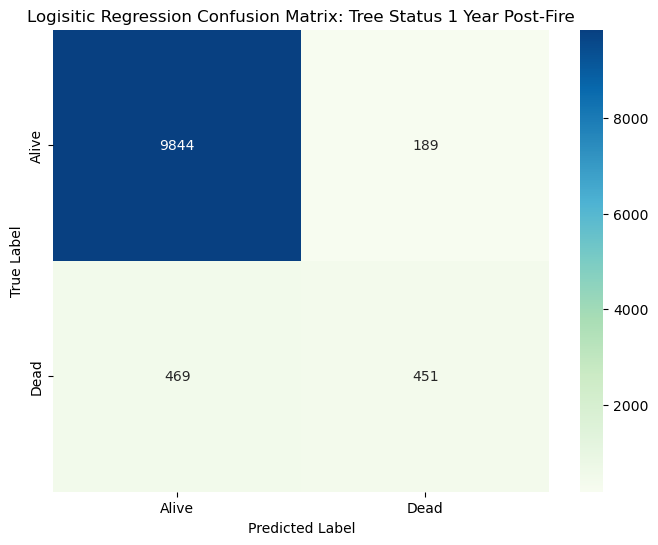

In [11]:
# Make predictions 
y_test_pred = log_reg.predict(X_test_scaled)

# Calculate accuracy 
accuracy_test = accuracy_score(y_test, y_test_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy_test * 100:.2f}%")

# Initialize confusion matrix 
cm = confusion_matrix(y_test, y_test_pred)

# Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu', # d = interger
               xticklabels = ['Alive', 'Dead'], # 0 = alive, 1 = dead
               yticklabels = ['Alive', 'Dead']) 
plt.title('Logisitic Regression Confusion Matrix: Tree Status 1 Year Post-Fire')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

## Step 6: Logistic Classifier Evaluation
How did your model perform on the unseen data? 
Does your model perform differently on observations of trees that survived vs trees that died?
Is there a class imbalance in this data set?

The logisitic model performed farily well on the unseen data, with an accuracy of 93% It does seems that there is a class imbalance in the data set, with far more tree labels as alive than dead. The confusion matrix reveals that 9,878 trees were correctly labeled as alive, and only 155 alive trees were miss labeled as dead. However, for the dead trees, 519 were miss labeled as alive and 401 were labeled correctly as dead. There are far less dead trees in the data, but the model seems to not be good at labeling them correctly. 

In [12]:
# Confirm class imbalance 
trees_complete['yr1status'].value_counts()

yr1status
0.0    33474
1.0     3035
Name: count, dtype: int64

## Step 7: What about a Dummy?
What do you think would happen if we built a model that always predicts the majority class (alive trees)? How would its accuracy compare to your logistic regression model?

If we built a model that always predicts the majority class, I think it would fair pretty similar to the logisitic regression model due to the data's class imbalance of having 91.7 % alive trees. So even if it miss labels the 8.3% of dead trees as alive, it would still ahve fairly high accuracy. 

Let's go ahead and do it: use `DummyClassifier()` with the appropriate value for the 'strategy' parameter to train a majority classifier.  Then calculate this model's accuracy on the training data.

Dummy Accuracy: 91.724057%

Dummy Confusion Matrix: 


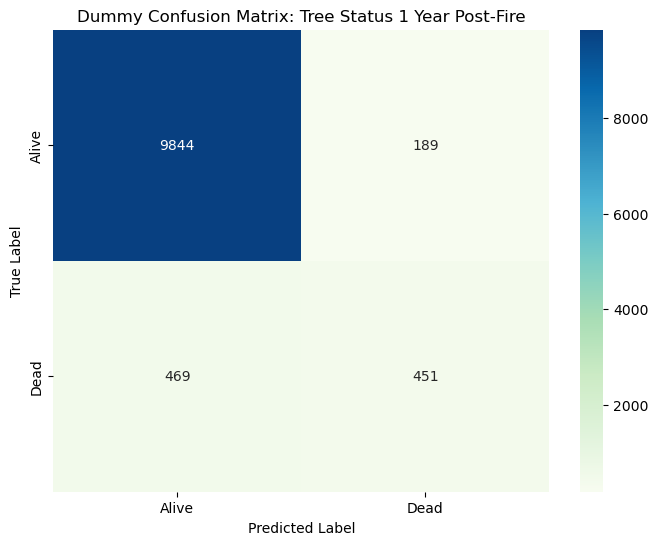

In [13]:
# Create dummy classifier for majority class 
dummy = DummyClassifier(strategy="most_frequent")

# Fit dummy classifier 
dummy.fit(X_train_scaled, y_train)

# Make predictions 
y_train_pred_dum = dummy.predict(X_train_scaled)

# Calculate accuracy 
accuracy_dummy = accuracy_score(y_train, y_train_pred_dum)

# Print accuracy and confusion matrix results
print(f"Dummy Accuracy: {accuracy_dummy * 100:2f}%")
print("\nDummy Confusion Matrix: ")

# Initialize confusion matrix 
cm_dummy = confusion_matrix(y_train, y_train_pred_dum)

# Plot confusion matrix
plt.figure(figsize = (8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'GnBu', # d = interger
               xticklabels = ['Alive', 'Dead'], # 0 = alive, 1 = dead
               yticklabels = ['Alive', 'Dead']) 
plt.title('Dummy Confusion Matrix: Tree Status 1 Year Post-Fire')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Step 8: ROCs and AUCs
Our two models have similar accuracy, but is that all there is to this story?  Let's dig a little deeper on the comparison of our logistic and dummy classifiers by examining the associated receiver-operator characteristic (ROC) curves. Calculate the area under the curve (AUC) for both models.

In [14]:
# Logistic classifier AUC
log_reg_auc = roc_auc_score(y_test, log_reg.predict_proba(X_test_scaled)[:,1])
print(f"Logistic AUC: {log_reg_auc:.3f} ")

Logistic AUC: 0.918 


In [15]:
# Dummy classifier AUC
dummy_auc = roc_auc_score(y_test, dummy.predict_proba(X_test_scaled)[:,1])
print(f"Dummy AUC: {dummy_auc:.3f}")

Dummy AUC: 0.500


# Step 9: Plot dummy and logistic model ROC curves
Now using the outputs from `roc_curve()`, plot the ROC curves for both models on the same plot.  Make sure to use appropriate labels in the legend.

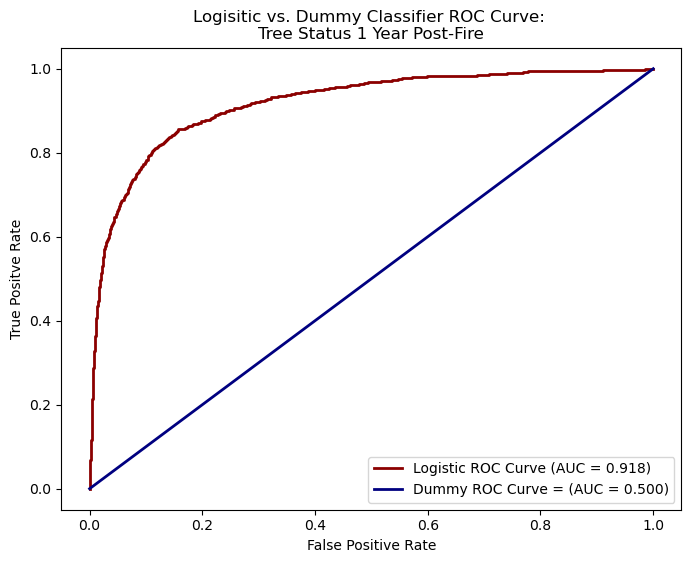

In [16]:
# Logistic regression ROC curve 
fpr_log, tpr_log, _ = roc_curve(y_test, log_reg.predict_proba(X_test_scaled)[:,1]) # underscore = ignore third value (thresholds)

# Dummy ROC curve 
fpr_dum, tpr_dum, _ = roc_curve(y_test, dummy.predict_proba(X_test_scaled)[:,1]) # underscore = ignore third value (thresholds)


# Plot 
plt.figure(figsize = (8,6))
# Log ROC curve 
plt.plot(fpr_log, tpr_log, color = 'darkred', lw = 2, label = f'Logistic ROC Curve (AUC = {log_reg_auc:.3f})')
# Dummy ROC curve 
plt.plot(fpr_dum, tpr_dum, color = 'navy', lw = 2, label = f'Dummy ROC Curve = (AUC = {dummy_auc:.3f})')
# Labels 
plt.xlabel('False Positive Rate')
plt.ylabel('True Positve Rate')
plt.title('Logisitic vs. Dummy Classifier ROC Curve: \nTree Status 1 Year Post-Fire')
# Legend 
plt.legend()
plt.show()


How do the two models compare on AUC?  What are the implications for evaluating classifiers based on accuracy of their predictions?

The ROC Curves of each of the models evaluates the true positve rate against the false positive rate. The results show that the area under the curve (AUC) for the logisitic regression is 0.918 and for the dummy classifier is 0.5. A higher AUC indicates better preformance, while a AUC score of 0.5 is basically the same as guessing. This indicates that the Logisitic regression model preforms better than the dummy classifier. If we were just to evaluate the two models based on their accuracy, we would assume they both are roughly the same since their accuracies are both greater than 90%, but the ROC curve shows that the dummy classifier is the equivalent to guessing. 

# Step 10: Final interpretation

Identifying the most important features in a model can guide decision-making. For instance, in our dataset, highly important features might indicate key factors affecting tree survival after a fire. We will calculate the feature importance by examining the coefficients of our logistic regression model.

In [17]:
# List features 
features = list(trees_complete.drop(['yr1status', 'YrFireName', 'Species', 'Genus_species'], axis = 1))

# List coefs 
coefs = list(log_reg.coef_[0])

# Zip lists together into df 
importance_df = pd.DataFrame(zip(features, coefs), columns=['Feature', 'Coefficient'])
                
# Print the sorted feature importance
print(importance_df)

             Feature  Coefficient
0       Times_burned     0.000000
1             DBH_cm     0.421324
2               HT_m    -1.165414
3             CR_pre     0.123414
4            CR_post    -2.494974
5     YrFireName_cat    -0.660497
6        Species_cat     0.541509
7  Genus_species_cat    -0.067867


Which are the most important features in our model (reference the metadata to help answer this)? Can you think of any implications for forest management or conservation strategy?

In evaluating the coefficients of a model, the the feature with the largest absolute coefficient value is usually considered the most important feature. By looking at the dataframe above, that would indicate that Post fire live crown ratio (CR_ratio) and pre-fire tree height (HT_m) are the top two features. In terms of resilancy to fire, this would mean that the tallests and widest trees are the most burn-resistant. In terms of forest management, it would be wise to preserve old tall trees to ensure a forest is not completely wiped out in a fire and has a better chance at regeneration.  